In [6]:
from tools.fpm_runner import set_composition, show, run, plot, read_envels, get_stable, crossed_point
import matplotlib.pyplot as plt
import numpy as np

comps = np.array([
    "N2",
    "CO2",
    "H2S",
    "C1",
    "C2",
    "C3",
    "iC4",
    "nC4",
    "iC5",
    "nC5",
    "C6",
    "C7-C25",
    "C26-C49",
    "C50-C64-PN",
    "C65-C80-PN",
    "C50-C80-A"
])

n_comps = len(comps)

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (7, 6)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [7]:
from glob import glob

points = {}
for file in glob("env23out/*CP"):  
    
    with open(file) as f:
        lines = f.readlines()
    
    if len(lines) > 1:
        print(file)
        points[file] = {"t": [], "p": []}
        
        for line in lines[1:]:
            t, p = line.split()
            
            t = float(t)
            p = float(p)
            
            points[file]["t"].append(t)
            points[file]["p"].append(p)


env23out/envelout-DEW-CP


In [11]:
%matplotlib
plt.clf()
#infile = "infiles/no_asph"
#infile = 'infiles/case2pri'

infile = "infiles/case2"
z = set_composition(infile, -1, 0.00105) # -> Autocruce

run("new_file", three_phase="yes")
plot(stable=False)

# z = set_composition(infile, -1, 0.0013) # -> Autocruce
# run("new_file", three_phase="yes")
# plot(stable=False)

# for file in points:
#     criticals = points[file]
#     for t, p in zip(criticals["t"], criticals["p"]):
#         plt.scatter(t, p, color="black")

plt.ylim(0, 300)
plt.show()

Using matplotlib backend: QtAgg
Case:  True True


FileNotFoundError: [Errno 2] No such file or directory: 'env23out/envelout-CROSS22'

In [3]:
%matplotlib widget

envels = read_envels()
for i in range(3):
    plt.scatter(envels["2phase"][i]["T"], envels["2phase"][i]["P"], alpha=0.3)

#envels = get_stable(envels, True, True)

#for i in range(3):
#    plt.plot(envels["2phase"][i]["T"], envels["2phase"][i]["P"], alpha=0.8)

envels = read_envels()
#plt.ylim(0, 150)

ModuleNotFoundError: No module named 'ipympl'

In [5]:
t = envels["2phase"][0][["T"]].values
p = envels["2phase"][0][["P"]].values

point_1 = envels["3phase"][0][["T", "P"]].values[0]
point_2 = envels["3phase"][2][["T", "P"]].values[0]

crossed_point(t, p, point_1)

(204, True)

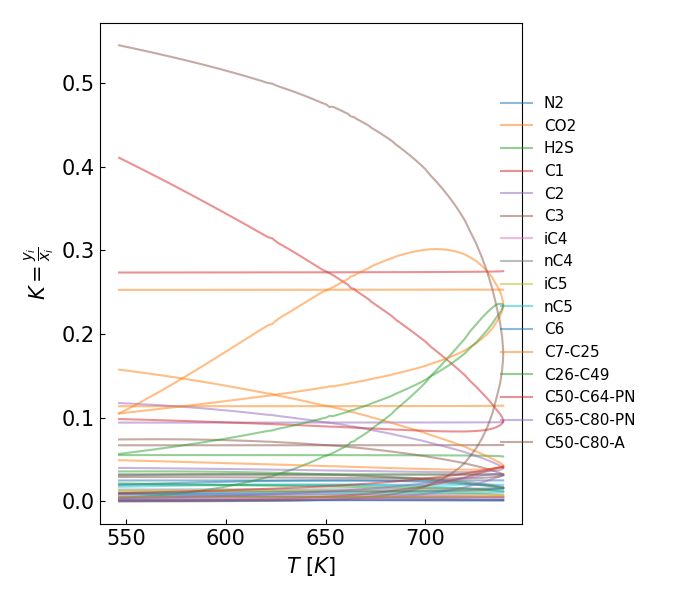

In [6]:
%matplotlib widget

fig, ax = plt.subplots()

index = "T"

numbers = [i for i in range(n_comps)]

prop = [f"x{i+1}" for i in numbers]
show(envels["3phase"][-2], index, prop, alpha=0.5)
plt.gca().set_prop_cycle(None)

prop = [f"y{i+1}" for i in numbers]
show(envels["3phase"][-2], index, prop, alpha=0.5)
plt.gca().set_prop_cycle(None)

prop = [f"w{i+1}" for i in numbers]
show(envels["3phase"][-2], index, prop, alpha=0.5)


#prop = [f"KS{i+1}" for i in numbers]
#show(envels["3phase"][-1], index, prop, alpha=0.5)


ax.set_xlabel(r"$T\ [K]$")
ax.set_ylabel(r"$K = \frac{y_i}{x_i}$")
ax.tick_params(direction="in")

lgnd = plt.legend(comps[numbers], bbox_to_anchor=(1.3, 0.5), loc="center right", frameon=False, fontsize=11)

plt.tight_layout()
#plt.xlim(600, None)
#plt.ylim(0, 5)
plt.show()

[[<matplotlib.lines.Line2D at 0x7fb0189f9540>],

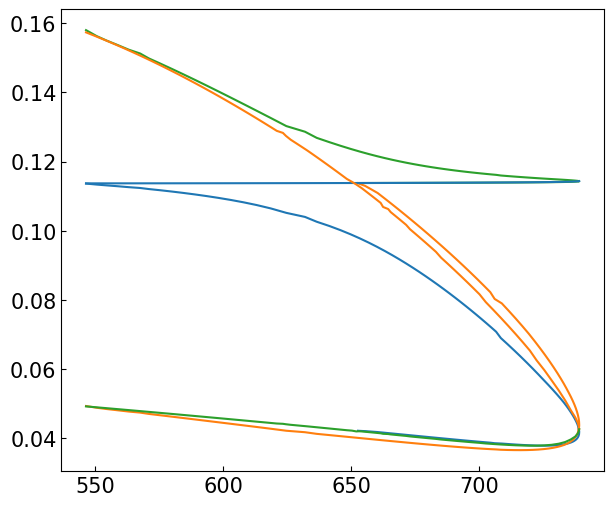

In [8]:
%matplotlib inline


[
    plt.plot(
        envels["3phase"][-1]["T"],
        envels["3phase"][-1][x]
    ) for x in ["x2", "y2", "w2"]
    
]
plt.gca().set_prop_cycle(None)

[
    plt.plot(
        envels["3phase"][-2]["T"],
        envels["3phase"][-2][x]
    ) for x in ["x2", "y2", "w2"]
    
]

# plt.title()

In [10]:
msk_1 = envels["3phase"][-1]["T"].diff() < 0
envel_1 = envels["3phase"][-1][msk_1]

msk_2 = envels["3phase"][-2]["T"] > 680
envel_2 = envels["3phase"][-2][msk_2]

plt.plot(envel_1["T"], envel_1["P"], alpha=0.5, color="red")
plt.plot(envel_2["T"], envel_2["P"], alpha=0.5)

[[<matplotlib.lines.Line2D at 0x7fb012fc71f0>],

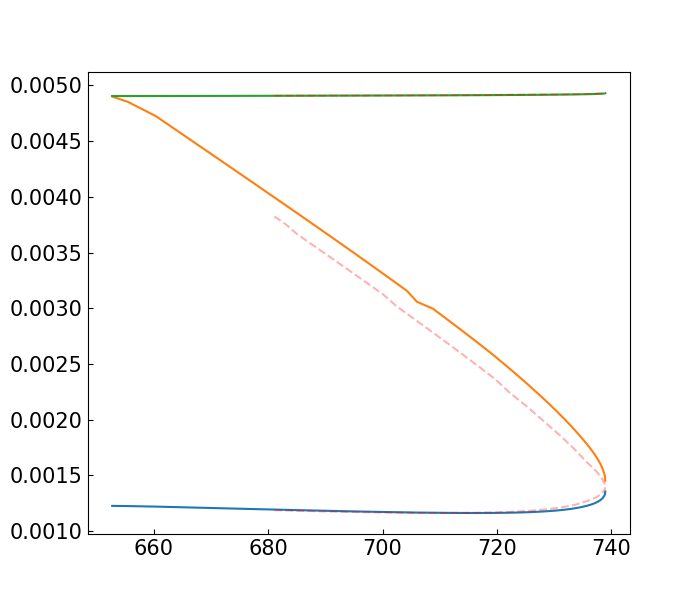

In [11]:
%matplotlib widget

fig, ax = plt.subplots()

comp = 1
[
    plt.plot(
        envel_1["T"],
        envel_1[x]
    ) for x in [f"x{comp}", f"y{comp}", f"w{comp}"]
    
]
plt.gca().set_prop_cycle(None)

[
    plt.plot(
        envel_2["T"],
        envel_2[x], color="red", alpha=0.3, ls='--'
    ) for x in [f"x{comp}", f"y{comp}", f"w{comp}"]
    
]

In [ ]:
import numpy as np
_ = np.array([1, 3, 2])
msk = [i for i in [0,2]]
_[msk]

In [ ]:
msk

In [ ]:
plt.scatter(envels["2phase"][0]["T"], envels["2phase"][0]["P"])
plt.show()

In [ ]:
%matplotlib inline
dew = envels["2phase"][1]

plt.plot(dew["T"], dew["P"])

In [ ]:
cricondenterm_i = np.where(dew["T"].diff() < 0)[0][0]

idx = dew["T"][cricondenterm_i:][dew["T"][cricondenterm_i:].diff() > 0].index

minT, maxT = dew["T"][idx].min(), dew["T"][idx].max()

region = dew[
    (dew["T"] >= minT) & (dew["T"] <= maxT + 10) & (dew["P"] > 10)
]

In [ ]:
plt.plot(region["T"], region["P"])

cricondenterm_i, minT, maxT

In [ ]:
plt.plot(dew["T"][idx], dew["P"][idx])

In [ ]:
idx